### Imports

In [1]:
from typing import Union
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import wordnet
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
import numpy as np
import tensorflow as tf

### Helper functions

In [2]:
def load_text_file(file_path: str) -> list[str]:
    """
    Load a text file and return an array of lines from the file.

    Args:
        file_path: str: The path to the file to load.

    Returns:
        list[str]: An array of lines from the file.
    """
    with open(file_path, "r", encoding="utf-8") as file:
        lines = file.readlines()
    return [line.strip() for line in lines]

### Load the text files

In [3]:
train_text_path: str = "../dataset/train_text.txt"
train_label_path: str = "../dataset/train_labels.txt"

test_text_path: str = "../dataset/test_text.txt"
test_label_path: str = "../dataset/test_labels.txt"

validationt_text_path: str = "../dataset/val_text.txt"
validationt_label_path: str = "../dataset/val_labels.txt"

train_text: list[str] = load_text_file(train_text_path)
train_label: list[str] = load_text_file(train_label_path)

test_text: list[str] = load_text_file(test_text_path)
test_label: list[str] = load_text_file(test_label_path)

validation_text: list[str] = load_text_file(validationt_text_path)
validation_label: list[str] = load_text_file(validationt_label_path)

## Kelvin's Part

### Preprocessing

In [4]:
# Set stopwords
nltk.download("stopwords", quiet=True)
nltk.download("punkt", quiet=True)
nltk.download("wordnet", quiet=True)
stopwords = set(nltk.corpus.stopwords.words("english"))
stopwords.update("i")

# Declare a dict of emojis and their corresponding sentiment
# 0: Negative; 1: Neutral; 2: Positive
emoji_dict = {
    "😊": 2,
    "😂": 2,
    "😭": 0,
    "😍": 2,
    "😘": 2,
    "😁": 2,
    "😩": 0,
    "😏": 2,
    "😉": 2,
    "😎": 2,
    "😢": 0,
    "😅": 2,
    "😱": 0,
    "😆": 2,
    "😋": 2,
    "😷": 0,
    "😔": 0,
    "😒": 0,
    "😡": 0,
    "😪": 0,
    "😤": 0,
    "😝": 2,
    "😓": 0,
    "😖": 0,
    "😣": 0,
    "😞": 0,
    "😐": 1,
    "😕": 0,
    "😫": 0,
    "😨": 0,
    "😌": 2,
    "😜": 2,
    "😑": 1,
    "😬": 0,
    "😈": 0,
    "😯": 0,
    "😳": 0,
    "😇": 2,
    "😷": 0,
    "😴": 0,
    "😲": 0,
    "😵": 0,
    "😦": 0,
    "😢": 0,
    "😮": 0,
    "😟": 0,
    "😥": 0,
    "😧": 0,
    "😰": 0,
    "😓": 0,
    "😩": 0,
    "😿": 0,
    "😾": 0,
    "🙀": 0,
    "🙅": 0,
    "🙆": 0,
    "🙇": 0,
    "🙈": 0,
    "🙉": 0,
    "🙊": 0,
    "🙋": 0,
    "🙌": 0,
    "🙍": 0,
    "🙎": 0,
    "🙏": 0,
    ":)": 2,
    ":(": 0,
    "❤️": 2,
    "👍": 2,
    "✌🏼️": 2,
    "☹️": 0,
    "👎": 0,
    "💙": 2,
    "💗": 2,
    "🎉": 2,
    "😄": 2,
    "🤗": 2,
    ":D": 2,
    "🎄": 2,
    "🎁": 2,
}

used_synonyms = set()

### Functions

In [5]:
def text_processing(text: list[str]) -> list[list[str]]:
    """
    Process text data:
    - Remove '@user'
    - Remove hashtags
    - Remove URLs
    - Replace emojis with their corresponding sentiment.
    - Replace punctuation marks.
    - Normalize the text with nltk.
    - Tokenize the text.
    - Lowercase the text.
    - Remove stop words.
    - Remove remaining punctuation.
    - Keep emojis.
    - Remove numbers.
    # Length of the line is added after vectorization.

    Args:
        text: list[str]: A list of text data.

    Returns:
        list[list[str]]: A list of list of processed text data.
    """
    processed_text = []
    lemmatizer = WordNetLemmatizer()
    for line in text:
        # Remove '@user'
        line = line.replace("@user", "")
        # Remove hashtags
        line = line.replace("#", "")
        # Remove URLs (http, https, www)
        line = " ".join([word for word in line.split() if "http" not in word])
        line = " ".join([word for word in line.split() if "www" not in word])
        # Replace emojis with their corresponding sentiment
        line = replace_emojis(line)
        # Replace punctuation marks
        line = punctuation_replacement(line)
        # Normalize the text using WordNetLemmatizer and tokenize the text
        tokens = nltk.word_tokenize(line)
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
        # Lowercase the text
        tokens = [str(word).lower() for word in tokens]
        # Remove stop words
        tokens = [word for word in tokens if word not in stopwords]
        # Remove remaining punctuation but keep emojis
        tokens = [word for word in tokens if word.isalnum() or word in emoji_dict]
        # Remove numbers
        tokens = [word for word in tokens if not word.isnumeric()]
        processed_text.append(tokens)

    return processed_text


def vectorize_text(
    input: list[list[str]], vocabulary: list[str]
) -> np.ndarray[np.ndarray[float]]:
    """
    Vectorize the text data.

    Args:
        input: list[list[str]]: A list of list of text data.
        vocabulary: list[str]: The list of most common words.

    Returns:
        np.ndarray[np.ndarray[float]]: A numpy array of vectorized text data.
    """
    vectorized_text = np.zeros((len(input), len(vocabulary)))
    for i, line in enumerate(input):
        for word in line:
            if word in vocabulary:
                vectorized_text[i, vocabulary.index(word)] += 1
    return vectorized_text


def map_emoji_sentiment(input: int) -> str:
    """
    Map the emoji sentiment to a string.

    Args:
        input: int: The emoji sentiment.

    Returns:
        str: The string sentiment.
    """
    if input == 0:
        return "bad"
    elif input == 1:
        return "neutral"
    elif input == 2:
        return "good"
    else:
        return "neutral"


def replace_emojis(input: str) -> str:
    """
    Replace emojis with their corresponding sentiment.
    If the emoji is 0, replace it with 'bad'.
    If the emoji is 1, replace it with 'neutral'.
    If the emoji is 2, replace it with 'good'.
    If the emoji is not in the emoji_dict, replace it with 'neutral'.

    Args:
        input: str: The input text data.

    Returns:
        str: The text data with emojis replaced with their corresponding sentiment.
    """
    for emoji in emoji_dict:
        if emoji in input:
            input = input.replace(emoji, map_emoji_sentiment(emoji_dict[emoji]))
    return input


def get_sentiment_score(line: list[str]) -> list[float]:
    """
    Get the sentiment score of the input text data.

    Args:
        line: list[str]: A line (list of str).

    Returns:
        list[float]: The compound score of 10 words in the sentence which has
        the most significant score (far from 0). If the sentence has less than
        10 words, the value of the remaining elements will be 0.
        After that, the score for the whole line is added to the list.
    """
    scores: list[float] = []
    analyzer = SentimentIntensityAnalyzer()
    for string in line:
        score = analyzer.polarity_scores(string)["compound"]
        scores.append(score)
    line_score = analyzer.polarity_scores(" ".join(line))["compound"]

    # Get the 10 most significant scores and add the line score
    if len(scores) > 10:
        scores.sort(key=lambda x: abs(x), reverse=True)
        result = scores[:10]
        result.append(line_score)
    else:
        result = scores
        result += [0] * (10 - len(scores))
        result.append(line_score)

    return result


def learning_rate_scheduler(epoch: int) -> float:
    """
    Learning rate scheduler.

    Args:
        epoch: int: The current epoch.

    Returns:
        float: The new learning rate.
    """
    if epoch < 10:
        return 0.0005
    elif epoch < 20:
        return 0.0003
    else: 
        return 0.0001


def punctuation_replacement(line: Union[str, list[str]]) -> str:
    """
    Check if there are repeated (>= 2) punctuation marks ['.' '!', '?'] in the line.
    If there are, no matter how many times the punctuation mark is repeated,
    replace it with ['MultiDot', 'MultiExclamation', 'MultiQuestion']
    respectively.

    Replace ['.' '!', '?'] with ['Dot', 'Exclamation', 'Question'] respectively.
    If they are not repeated in the line, keep them as they are.

    Args:
        line: Union[str, list[str]]: The input line.

    Returns:
        str: The line with punctuation marks replaced.
    """
    # Split the line into words if it is a string
    if type(line) is str:
        line = line.split()
    # Replace punctuation marks
    for_append = []
    for i, word in enumerate(line):
        if word.count(".") >= 2:
            line[i] = line[i].replace(".", "")
            for_append.append("MultiDot")
        elif word.count("!") >= 2:
            line[i] = line[i].replace("!", "")
            for_append.append("MultiExclamation")
        elif word.count("?") >= 2:
            line[i] = line[i].replace("?", "")
            for_append.append("MultiQuestion")
        elif word.count(".") == 1:
            line[i] = line[i].replace(".", "")
            for_append.append("Dot")
        elif word.count("!") == 1:
            line[i] = line[i].replace("!", "")
            for_append.append("Exclamation")
        elif word.count("?") == 1:
            line[i] = line[i].replace("?", "")
            for_append.append("Question")
    
    line += for_append

    # Join back the line
    return " ".join(line)


### Process the text data

In [6]:
# Process all text data
train_text: list[list[str]] = text_processing(train_text)
test_text: list[list[str]] = text_processing(test_text)
validation_text: list[list[str]] = text_processing(validation_text)

In [7]:
# Get the length of each line in the 3 text data
train_text_len: list[int] = [len(line) for line in train_text]
test_text_len: list[int] = [len(line) for line in test_text]
validation_text_len: list[int] = [len(line) for line in validation_text]

In [8]:
# Find index of lists in train_text and validation_text that are empty
empty_index_train = [i for i, x in enumerate(train_text) if not x]
empty_index_validation = [i for i, x in enumerate(validation_text) if not x]

# Remove empty lists from train_text and validation_text, and corresponding labels
train_text: list[list[str]] = [
    train_text[i] for i in range(len(train_text)) if i not in empty_index_train
]
train_label: list[list[str]] = [
    train_label[i] for i in range(len(train_label)) if i not in empty_index_train
]
validation_text: list[list[str]] = [
    validation_text[i]
    for i in range(len(validation_text))
    if i not in empty_index_validation
]
validation_label: list[list[str]] = [
    validation_label[i]
    for i in range(len(validation_label))
    if i not in empty_index_validation
]

In [9]:
# Find the most common words in the training data
word_frequency: dict[str, int] = {}
for line in train_text:
    for word in line:
        if word in word_frequency:
            word_frequency[word] += 1
        else:
            word_frequency[word] = 1

vocabulary: list[str] = [
    word
    for word, _ in sorted(word_frequency.items(), key=lambda x: x[1], reverse=True)[
        :10000
    ]
]

In [10]:
# Convert the labels to integers
train_label: list[int] = [int(label) for label in train_label]
test_label: list[int] = [int(label) for label in test_label]
validation_label: list[int] = [int(label) for label in validation_label]

### Vectorize the input

In [11]:
# Vectorize the text data
train_vectorized: np.ndarray[np.ndarray[float]] = vectorize_text(train_text, vocabulary)
test_vectorized: np.ndarray[np.ndarray[float]] = vectorize_text(test_text, vocabulary)
validation_vectorized: np.ndarray[np.ndarray[float]] = vectorize_text(
    validation_text, vocabulary
)

# Get the sentiment score of the text data
train_sentiment_score: np.ndarray[np.ndarray[float]] = np.array(
    [get_sentiment_score(line) for line in train_text]
)
test_sentiment_score: np.ndarray[np.ndarray[float]] = np.array(
    [get_sentiment_score(line) for line in test_text]
)
validation_sentiment_score: np.ndarray[np.ndarray[float]] = np.array(
    [get_sentiment_score(line) for line in validation_text]
)

# Add the length of the text data to the vectorized data
train_vectorized = np.column_stack((train_vectorized, train_text_len))
test_vectorized = np.column_stack((test_vectorized, test_text_len))
validation_vectorized = np.column_stack((validation_vectorized, validation_text_len))

In [12]:
# Find the entries with all zeros in the vectorized data
zero_index_train: np.ndarray[int] = np.where(~train_vectorized.any(axis=1))[0]
zero_index_validation: np.ndarray[int] = np.where(~validation_vectorized.any(axis=1))[0]

print("Original training data size:", len(train_vectorized))
print("Original validation data size:", len(validation_vectorized))

# Remove entries with all zeros in the vectorized data, and corresponding labels
train_vectorized: np.ndarray[np.ndarray[float]] = np.delete(
    train_vectorized, zero_index_train, axis=0
)
train_label: list[int] = [
    train_label[i] for i in range(len(train_label)) if i not in zero_index_train
]
validation_vectorized: np.ndarray[np.ndarray[float]] = np.delete(
    validation_vectorized, zero_index_validation, axis=0
)
validation_label: list[int] = [
    validation_label[i]
    for i in range(len(validation_label))
    if i not in zero_index_validation
]

# Remove entries with all zeros in the sentiment score data
train_sentiment_score: np.ndarray[np.ndarray[float]] = np.delete(
    train_sentiment_score, zero_index_train, axis=0
)
validation_sentiment_score: np.ndarray[np.ndarray[float]] = np.delete(
    validation_sentiment_score, zero_index_validation, axis=0
)

print("Processed training data size:", len(train_vectorized))
print("Processed validation data size:", len(validation_vectorized))

Original training data size: 45615
Original validation data size: 2000
Processed training data size: 45615
Processed validation data size: 2000


In [13]:
# Add sentiment score to each entry in the vectorized data
train_vectorized = np.concatenate((train_vectorized, train_sentiment_score), axis=1)
test_vectorized = np.concatenate((test_vectorized, test_sentiment_score), axis=1)
validation_vectorized = np.concatenate(
    (validation_vectorized, validation_sentiment_score), axis=1
)

In [14]:
print("Training data shape:", train_vectorized.shape)

Training data shape: (45615, 10012)


### NN

In [15]:
# Convert the labels to one-hot encoding
train_label_one_hot: np.ndarray[np.ndarray[float]] = tf.one_hot(train_label, 3)
validation_label_one_hot: np.ndarray[np.ndarray[float]] = tf.one_hot(
    validation_label, 3
)

# Create an Input layer
input_layer = tf.keras.layers.Input(shape=(train_vectorized.shape[1],))

dropout_rate = 0.7

# Define the model
model = tf.keras.models.Sequential(
    [
        input_layer,
        tf.keras.layers.Dense(2048, activation="sigmoid"),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(512, activation="sigmoid"),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(128, activation="sigmoid"),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(3, activation="softmax"),
    ]
)

# Define early stopping criteria
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, mode="min", verbose=1
)

# Add parameters to Adam optimizer if needed
modified_adam = tf.keras.optimizers.Adam()

model.compile(
    optimizer=modified_adam, loss="categorical_crossentropy", metrics=["accuracy"]
)

rate_scheduler = tf.keras.callbacks.LearningRateScheduler(learning_rate_scheduler)

# Train the model
history = model.fit(
    train_vectorized,
    train_label_one_hot,
    validation_data=(validation_vectorized, validation_label_one_hot),
    epochs=200,
    batch_size=512,
    callbacks=[early_stopping, rate_scheduler],
)

Epoch 1/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 16s 164ms/step - accuracy: 0.4152 - loss: 1.1921 - val_accuracy: 0.4345 - val_loss: 1.0202 - learning_rate: 5.0000e-04
Epoch 2/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 160ms/step - accuracy: 0.4394 - loss: 1.0324 - val_accuracy: 0.4345 - val_loss: 1.0193 - learning_rate: 5.0000e-04
Epoch 3/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 160ms/step - accuracy: 0.4465 - loss: 1.0219 - val_accuracy: 0.4345 - val_loss: 1.0194 - learning_rate: 5.0000e-04
Epoch 4/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 160ms/step - accuracy: 0.4468 - loss: 1.0218 - val_accuracy: 0.4345 - val_loss: 1.0178 - learning_rate: 5.0000e-04
Epoch 5/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 160ms/step - accuracy: 0.4480 - loss: 1.0203 - val_accuracy: 0.4345 - val_loss: 1.0153 - learning_rate: 5.0000e-04
Epoch 6/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 161ms/step - accuracy: 0.4569 - loss: 1.0132 - val_accuracy: 0.4765 - val_loss: 0.9909 - learning_rate: 5.0000e-04
Epoch 7/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 162ms/ste

In [16]:
# Evaluate the model
test_label_one_hot: np.ndarray[np.ndarray[float]] = tf.one_hot(test_label, 3)
test_loss, test_accuracy = model.evaluate(test_vectorized, test_label_one_hot)
print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)

384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6294 - loss: 0.8473
Test loss: 0.8550853133201599
Test accuracy: 0.6258547902107239


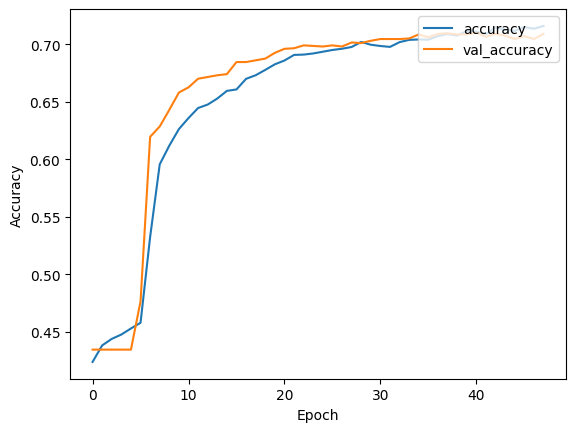

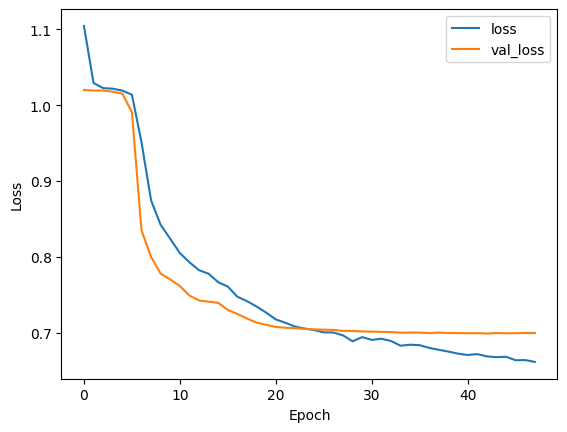

In [17]:
# Plot the training and validation accuracy
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="upper right")
plt.show()

# Plot the training and validation loss
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()